# CloudSeg: Training & Visualization

This notebook will train your `SimpleSegModel` on the SWINySEG data and visualize:

- A sample image & mask
- Training vs. validation loss curves
- IoU metric per epoch
- A metrics table and its correlation matrix
- Side-by-side sample predictions

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from src.data_loader import get_simple_loaders
from src.model import SimpleSegModel

import matplotlib.pyplot as plt
import pandas as pd


In [3]:
# Hyperparameters
BATCH_SIZE = 4
IMG_SIZE   = (256, 256)
LR         = 1e-3
MAX_EPOCHS = 20

# Create loaders (train & val)
train_loader = get_simple_loaders(
    images_dir="data/raw/images",
    masks_dir="data/raw/masks",
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    normalize=True,
    shuffle=True
)
val_loader = get_simple_loaders(
    images_dir="data/raw/images",
    masks_dir="data/raw/masks",
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    normalize=True,
    shuffle=False
)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.64].


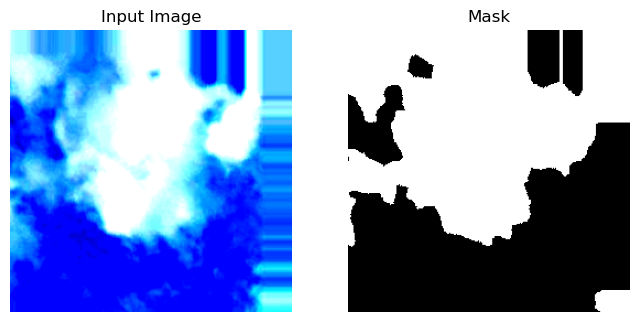

In [4]:
imgs, masks = next(iter(train_loader))

fig, axes = plt.subplots(1,2, figsize=(8,4))
axes[0].imshow(imgs[0].permute(1,2,0))
axes[0].set_title("Input Image")
axes[0].axis("off")
axes[1].imshow(masks[0,0], cmap="gray")
axes[1].set_title("Mask")
axes[1].axis("off")
plt.show()


In [5]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Running on:", device)

model     = SimpleSegModel().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# Lists to record
train_losses = []
val_losses   = []
val_ious     = []

for epoch in range(1, MAX_EPOCHS+1):
    # ── Training ──
    model.train()
    running_train_loss = 0.0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss    = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
    train_loss = running_train_loss / len(train_loader)
    
    # ── Validation ──
    model.eval()
    running_val_loss = 0.0
    intersection, union = 0.0, 0.0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            running_val_loss += criterion(outputs, masks).item()
            preds = (torch.sigmoid(outputs) > 0.5).float()
            intersection += (preds * masks).sum().item()
            union        += (preds + masks).sum().item() - (preds * masks).sum().item()
    val_loss = running_val_loss / len(val_loader)
    val_iou  = (intersection + 1e-6) / (union + 1e-6)
    
    # Record & print
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_ious.append(val_iou)
    print(f"Epoch {epoch}/{MAX_EPOCHS} — "
          f"train_loss: {train_loss:.4f}, "
          f"val_loss: {val_loss:.4f}, "
          f"val_iou: {val_iou:.4f}")


Running on: cuda:0
Epoch 1/20 — train_loss: 0.3170, val_loss: 0.2933, val_iou: 0.7830
Epoch 2/20 — train_loss: 0.2823, val_loss: 0.2777, val_iou: 0.7956
Epoch 3/20 — train_loss: 0.2730, val_loss: 0.2699, val_iou: 0.8044
Epoch 4/20 — train_loss: 0.2709, val_loss: 0.2656, val_iou: 0.8083
Epoch 5/20 — train_loss: 0.2683, val_loss: 0.2697, val_iou: 0.8028
Epoch 6/20 — train_loss: 0.2686, val_loss: 0.2718, val_iou: 0.8088
Epoch 7/20 — train_loss: 0.2674, val_loss: 0.2718, val_iou: 0.8058
Epoch 8/20 — train_loss: 0.2663, val_loss: 0.2641, val_iou: 0.8101
Epoch 9/20 — train_loss: 0.2662, val_loss: 0.2612, val_iou: 0.8084
Epoch 10/20 — train_loss: 0.2656, val_loss: 0.2594, val_iou: 0.8114
Epoch 11/20 — train_loss: 0.2639, val_loss: 0.2588, val_iou: 0.8096
Epoch 12/20 — train_loss: 0.2621, val_loss: 0.2603, val_iou: 0.8143
Epoch 13/20 — train_loss: 0.2619, val_loss: 0.2576, val_iou: 0.8099
Epoch 14/20 — train_loss: 0.2615, val_loss: 0.2577, val_iou: 0.8115
Epoch 15/20 — train_loss: 0.2608, val_

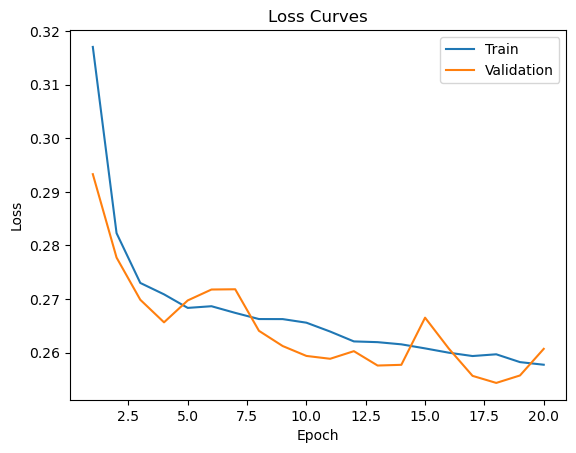

In [6]:
plt.figure()
plt.plot(range(1, MAX_EPOCHS+1), train_losses, label="Train")
plt.plot(range(1, MAX_EPOCHS+1), val_losses,   label="Validation")
plt.title("Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [7]:
metrics_df = pd.DataFrame({
    "epoch":       list(range(1, MAX_EPOCHS+1)),
    "train_loss":  train_losses,
    "val_loss":    val_losses,
    "val_iou":     val_ious
}).set_index("epoch")

metrics_df


,train_loss,val_loss,val_iou
epoch,,,
1,0.317039,0.293291,0.783034
2,0.282285,0.277731,0.795601
3,0.272995,0.269855,0.804422
4,0.270867,0.265643,0.808300
5,0.268336,0.269733,0.802823
6,0.268648,0.271765,0.808772
7,0.267407,0.271813,0.805773
8,0.266255,0.264059,0.810072
9,0.266246,0.261221,0.808371


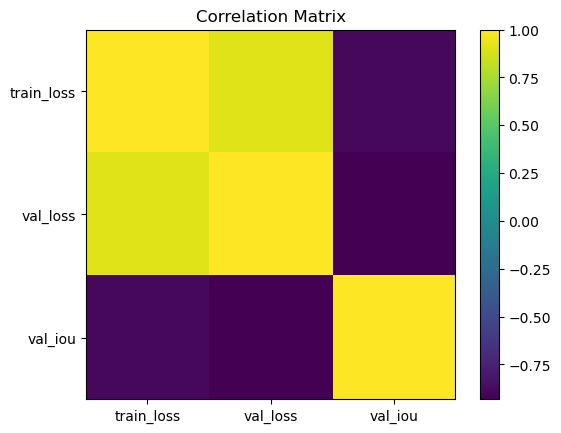

In [8]:
corr = metrics_df.corr()
plt.figure()
plt.imshow(corr, interpolation="nearest")
plt.title("Correlation Matrix")
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.index)
plt.colorbar()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0904187..1.8731157].


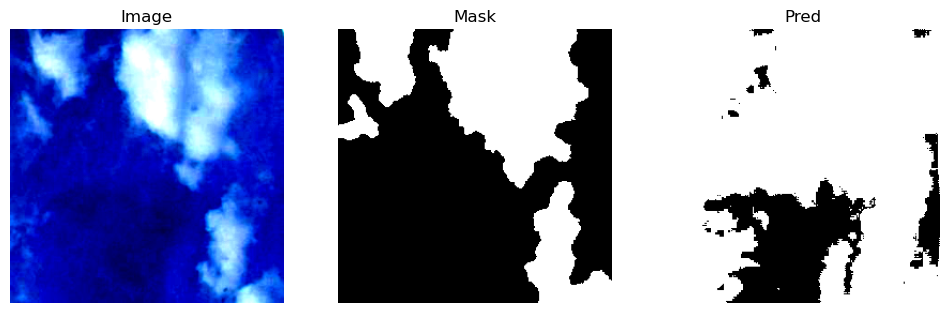

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.5702832].


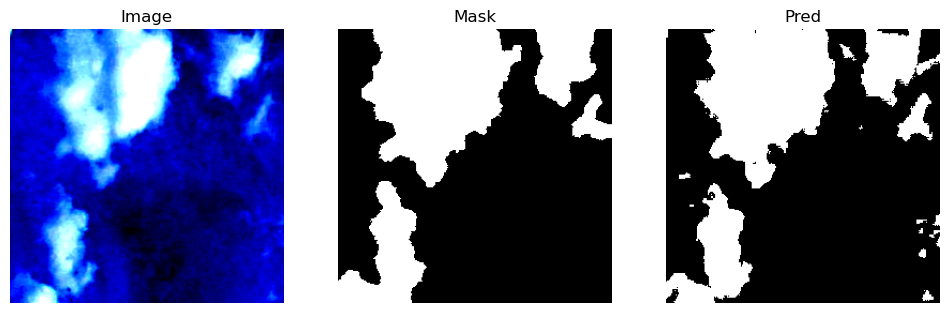

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.6051416].


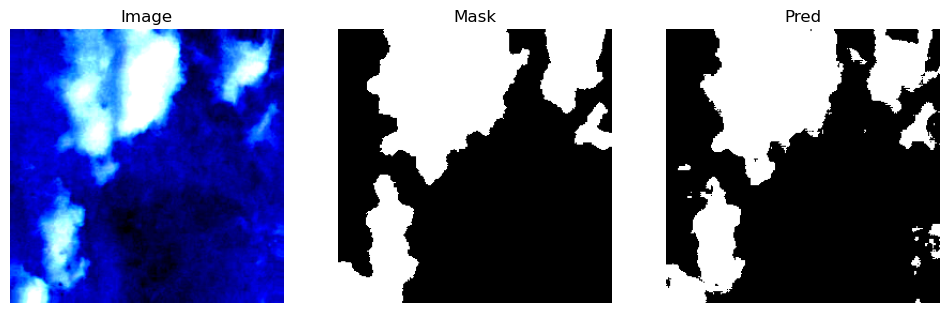

In [9]:
# Grab a few from the val set
imgs, masks = next(iter(val_loader))
outputs     = model(imgs.to(device)).cpu()
preds       = (torch.sigmoid(outputs) > 0.5).float()

for i in range(3):
    fig, axes = plt.subplots(1,3, figsize=(12,4))
    axes[0].imshow(imgs[i].permute(1,2,0)); axes[0].set_title("Image"); axes[0].axis("off")
    axes[1].imshow(masks[i,0], cmap="gray");        axes[1].set_title("Mask");  axes[1].axis("off")
    axes[2].imshow(preds[i,0], cmap="gray");        axes[2].set_title("Pred");  axes[2].axis("off")
    plt.show()
